<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_07_24_CNN_Multi_layer_with_pooling_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Multi-Layer With Pooling Prototype

Based on the [CNN Multi-Layer Prototype](https://github.com/sv650s/sb-capstone/blob/master/2019_07_23_CNN_Multi_layer_prototype.ipynb), we run the following variations so we can compare results

Since 3 layer CNN performed slight better in the previous notebook, we will start with that and add:
* max pooling in between all CNN layers
* instead of using early stop, we will run 15 epochs and compare results

We are going to save off the metrics for both models so we can print them out and compare them

As before, I am using some utility functions so I don't have copy so much code around. Source code for the modules are here:
* [dict_util](https://github.com/sv650s/sb-capstone/blob/master/util/dict_util.py)
* [plot_util](https://github.com/sv650s/sb-capstone/blob/master/util/plot_util.py)
* [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py)
* [file_util](https://github.com/sv650s/sb-capstone/blob/master/util/file_util.py)

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
sys.path.append('drive/My Drive/Springboard/capstone')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import matplotlib.pyplot as plt
import seaborn as sns

# custom utilities
import util.dict_util as du
import util.plot_util as pu
import util.keras_util as ku
import util.file_util as fu


sns.set()

DRIVE_DIR = "drive/My Drive/Springboard/capstone"
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
FEATURE_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"



Using TensorFlow backend.


In [0]:
# load data file
df = pd.read_csv(f"{DATA_FILE}")

# extract feature and label columns
rating = df[FEATURE_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

Same as previous notebooks but consolidated to one cell to make thing easier to understand

Features:
* tokenize our review body - this gives us:
  * vocab size: 40788 words
* then we will pad the sequences to length 186 since this encapsulates 99% of the lenght of our training data

Labels:
* one hot encode our star rating labels (y)


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

# figure out 99% percentile for our max sequence length
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
MAX_SEQUENCE_LENGTH = int(df.review_length.quantile([0.99]).values[0])
print(f'Max Sequence Length: {MAX_SEQUENCE_LENGTH}')

# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


# Build Our 3 Layer Model With Pooling In Between Layers

* we will use embedding size of 300 since this gave us slight improvement from previous notebook for class 1 and 2

In [0]:
MODEL_NAME3 = "CNN_3layer_with_pooling_early_stop"
EMBED_SIZE = 300
EPOCHS  = 15
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1


In [6]:
model3 = Sequential()
model3.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model3.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(250, activation='relu'))
model3.add(Dense(5, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


W0725 17:28:02.534390 140548307416960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 17:28:02.557205 140548307416960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 17:28:02.561341 140548307416960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 17:28:02.597107 140548307416960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0725 17:28:02.682382 140548307416960 deprecation_wrapp

In [7]:
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 186, 100)          90100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 93, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 93, 100)           30100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 46, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 100)           30100     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 23, 100)           0         
__________

In [8]:
# this is ame as before
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
network_history3 = model3.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0725 17:28:02.850344 140548307416960 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0725 17:28:02.995320 140548307416960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 67225 samples, validate on 16807 samples
Epoch 1/15
67225/67225 [==============================] - 357s 5ms/step - loss: 0.9423 - acc: 0.6372 - val_loss: 0.8702 - val_acc: 0.6647
Epoch 2/15
67225/67225 [==============================] - 360s 5ms/step - loss: 0.7416 - acc: 0.7095 - val_loss: 0.8543 - val_acc: 0.6725
Epoch 3/15
67225/67225 [==============================] - 359s 5ms/step - loss: 0.6117 - acc: 0.7609 - val_loss: 0.9391 - val_acc: 0.6629
Epoch 4/15
67225/67225 [==============================] - 363s 5ms/step - loss: 0.4856 - acc: 0.8129 - val_loss: 1.0135 - val_acc: 0.6563
Epoch 00004: early stopping


## Get Metrics for our 3 Layer Model with Pooling

In [9]:
# get scores
scores3 = model3.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores3[1]*100))

28011/28011 [==============================] - 37s 1ms/step
Accuracy: 65.97%


In [0]:
y_predict3 = model3.predict(X_test)

In [0]:
y_predict_unencoded3 = ku.unencode(y_predict3)
y_test_unencoded = ku.unencode(y_test)

In [0]:
cm3 = confusion_matrix(y_test_unencoded, y_predict_unencoded3)

In [0]:
roc_auc3, fpr3, tpr3 = ku.calculate_roc_auc(y_test, y_predict3)

## Save our model

In [0]:
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{INBASENAME}-nosmote-{MODEL_NAME3}-{MAX_SEQUENCE_LENGTH}-{FEATURE_COLUMN}"
MODEL_FILE = f"{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
REPORT_FILE = f"{DRIVE_DIR}/reports/{datetime.now().strftime(DATE_FORMAT)}-DNN_protype-report.csv"
TOKENIZER_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-tokenizer.pkl'

model3.save(MODEL_FILE)
pickle.dump(network_history3, open(NETWORK_HISTORY_FILE, "wb"))
pickle.dump(t, open(TOKENIZER_FILE, "wb"))

## Generate and save our Report

In [0]:
# generate report dictionary
report = {}
report = du.add_dict_to_dict(report, classification_report(y_test_unencoded, y_predict_unencoded3, output_dict=True))
report = du.add_dict_to_dict(report, roc_auc3)
report["confusion_matrix"] = cm3
report["tpr"] = tpr3
report["fpr"] = fpr3
report["loss"] = scores3[0]
report["accuracy"] = scores3[1]
report["description"] = DESCRIPTION
report["file"] = DATA_FILE
report["network_history_file"] = NETWORK_HISTORY_FILE
report["tokenizer_file"] = TOKENIZER_FILE
report["max_sequence_length"] = MAX_SEQUENCE_LENGTH
report["embedding"] = EMBED_SIZE
report["model_file"] = MODEL_FILE
report["model_name"] = MODEL_NAME3
report["test_examples"] = X_test.shape[0]
report["test_features"] = X_test.shape[1]
report["train_examples"] = X_train.shape[0]
report["train_features"] = X_train.shape[1]
report["status"] = "success"
report["status_date"] = datetime.now().strftime(TIME_FORMAT)

In [17]:
# check to see if report file exisits, if so load it and append
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(report, ignore_index=True)
# save report
report_df.to_csv(REPORT_FILE, index=False)

report_df.head()

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,3_recall,3_support,4_f1-score,4_precision,4_recall,4_support,5_f1-score,5_precision,5_recall,5_support,accuracy,auc_1,auc_2,auc_3,auc_4,auc_5,auc_macro,auc_micro,confusion_matrix,description,embedding,file,fpr,loss,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,max_sequence_length,model_file,model_name,network_history_file,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
0,0.699892,0.668502,0.734375,3968.0,0.208247,0.291627,0.161945,1871.0,0.309842,0.317823,0.302252,2531.0,0.349922,0.40936,0.305556,4752.0,0.82693,0.783,0.876083,14889.0,0.659669,0.944717,0.847903,0.809665,0.731212,0.872641,0.841251,0.89964,"[[2914, 352, 369, 86, 247], [721, 303, 466, 16...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,drive/My Drive/Springboard/capstone/data/amazo...,"{0: [0.0, 0.0, 0.0, 4.159214740257039e-05, 4.1...",1.011368,0.478967,0.494062,0.476042,28011.0,186.0,drive/My Drive/Springboard/capstone/models/201...,CNN_3layer_with_pooling_early_stop,drive/My Drive/Springboard/capstone/models/201...,success,2019-07-25 18:13:11,28011.0,186.0,drive/My Drive/Springboard/capstone/models/201...,"{0: [0.0, 0.00025201612903225806, 0.0022681451...",84032.0,186.0,0.639963,0.62854,0.659669,28011.0


# Build Our 3 Layer Model With Pooling In Between Layers - Do not use early stop this time

* we will use embedding size of 300 since this gave us slight improvement from previous notebook for class 1 and 2

In [18]:
MODEL_NAME = "CNN_3layer_with_pooling_10_epoch"

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

network_history = model.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2)

Train on 67225 samples, validate on 16807 samples
Epoch 1/15
67225/67225 [==============================] - 370s 6ms/step - loss: 1.0518 - acc: 0.6063 - val_loss: 0.9496 - val_acc: 0.6413
Epoch 2/15
67225/67225 [==============================] - 369s 5ms/step - loss: 0.8582 - acc: 0.6757 - val_loss: 0.9299 - val_acc: 0.6503
Epoch 3/15
67225/67225 [==============================] - 367s 5ms/step - loss: 0.7333 - acc: 0.7237 - val_loss: 0.9971 - val_acc: 0.6418
Epoch 4/15
67225/67225 [==============================] - 368s 5ms/step - loss: 0.6226 - acc: 0.7697 - val_loss: 1.1064 - val_acc: 0.6172
Epoch 5/15
67225/67225 [==============================] - 369s 5ms/step - loss: 0.5242 - acc: 0.8096 - val_loss: 1.2675 - val_acc: 0.5978
Epoch 6/15
67225/67225 [==============================] - 369s 5ms/step - loss: 0.4451 - acc: 0.8400 - val_loss: 1.5238 - val_acc: 0.5979
Epoch 7/15
67225/67225 [==============================] - 370s 6ms/step - loss: 0.3891 - acc: 0.8638 - val_loss: 1.7009 - 

In [0]:
MODEL_NAME = "CNN_3layer_with_pooling_15_epoch"


## Get Metrics


In [19]:
# get scores
scores = model.evaluate(X_test, y_test, verbose=1)

28011/28011 [==============================] - 33s 1ms/step


In [0]:
y_predict = model.predict(X_test)

In [0]:
y_predict_unencoded = ku.unencode(y_predict)
y_test_unencoded = ku.unencode(y_test)

In [0]:
cm = confusion_matrix(y_test_unencoded, y_predict_unencoded)

In [0]:
# get ROC/AUC
roc_auc, fpr, tpr = ku.calculate_roc_auc(y_test, y_predict)

## Save off our model files

In [0]:
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{INBASENAME}-nosmote-{MODEL_NAME}-{MAX_SEQUENCE_LENGTH}-{FEATURE_COLUMN}"
MODEL_FILE = f"{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
REPORT_FILE = f"{DRIVE_DIR}/reports/{datetime.now().strftime(DATE_FORMAT)}-DNN_protype-report.csv"
TOKENIZER_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-tokenizer.pkl'

model.save(MODEL_FILE)
pickle.dump(network_history, open(NETWORK_HISTORY_FILE, "wb"))
pickle.dump(t, open(TOKENIZER_FILE, "wb"))

## Save off the report

In [0]:
# generate report dictionary
report = {}
report = du.add_dict_to_dict(report, classification_report(y_test_unencoded, y_predict_unencoded, output_dict=True))
report = du.add_dict_to_dict(report, roc_auc)
report["confusion_matrix"] = cm
report["tpr"] = tpr
report["fpr"] = fpr
report["loss"] = scores[0]
report["accuracy"] = scores[1]
report["description"] = DESCRIPTION
report["file"] = DATA_FILE
report["network_history_file"] = NETWORK_HISTORY_FILE
report["tokenizer_file"] = TOKENIZER_FILE
report["max_sequence_length"] = MAX_SEQUENCE_LENGTH
report["embedding"] = EMBED_SIZE
report["model_file"] = MODEL_FILE
report["model_name"] = MODEL_NAME
report["test_examples"] = X_test.shape[0]
report["test_features"] = X_test.shape[1]
report["train_examples"] = X_train.shape[0]
report["train_features"] = X_train.shape[1]
report["status"] = "success"
report["status_date"] = datetime.now().strftime(TIME_FORMAT)



In [0]:
# check to see if report file exisits, if so load it and append
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(report, ignore_index=True)
# save report
report_df.to_csv(REPORT_FILE, index=False)



# Print metrics for the 2 models and compare


* look at accuracy scores
* epoch vs loss and accuarcy
* confusion matrix
* ROC/AUC plot

In [0]:
TITLE_NO_POOLING = "Pooling At the End"
TITLE_POOLING = "No Pooling"

In [28]:
print(f"Accuracy - {TITLE_POOLING}: %.2f%%" % (scores3[1]*100))
print(f"Accuracy - {TITLE_NO_POOLING}: %.2f%%" % (scores[1]*100))

Accuracy - No Pooling: 65.97%
Accuracy - Pooling At the End: 59.83%


No Pooling


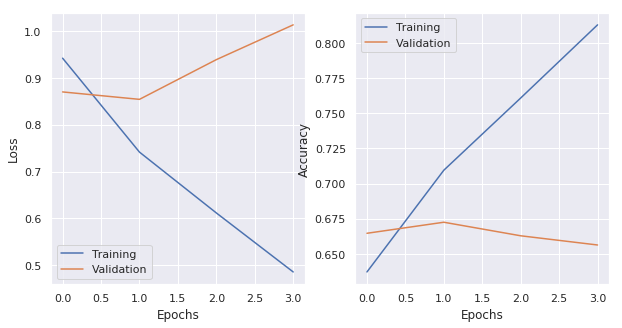

In [30]:
print(TITLE_POOLING)
pu.plot_network_history(network_history3)

Pooling At the End


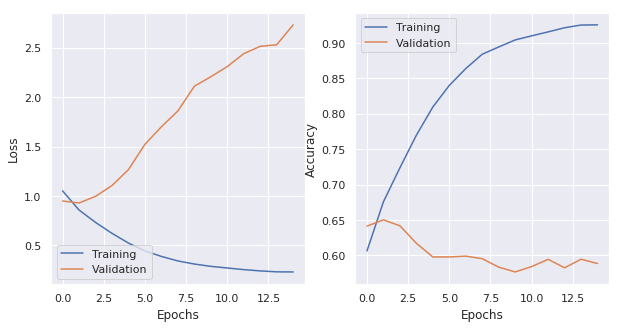

In [31]:
print(TITLE_NO_POOLING)
pu.plot_network_history(network_history)

In [35]:
print(f"Confusion matrix - {TITLE_POOLING}")
cm3

Confusion matrix - No Pooling


array([[ 2914,   352,   369,    86,   247],
       [  721,   303,   466,   167,   214],
       [  395,   252,   765,   557,   562],
       [  139,    77,   492,  1452,  2592],
       [  190,    55,   315,  1285, 13044]])

In [34]:
print(f"Confusion matrix - {TITLE_NO_POOLING}")
cm

Confusion matrix - Pooling At the End


array([[ 2221,   734,   346,   122,   545],
       [  534,   463,   355,   172,   347],
       [  344,   433,   634,   483,   637],
       [  175,   215,   540,  1387,  2435],
       [  344,   178,   453,  1860, 12054]])

In [36]:
print(f"Classification Report - {TITLE_POOLING}")
print(classification_report(y_test_unencoded, y_predict_unencoded3))

Classification Report - No Pooling
              precision    recall  f1-score   support

           1       0.67      0.73      0.70      3968
           2       0.29      0.16      0.21      1871
           3       0.32      0.30      0.31      2531
           4       0.41      0.31      0.35      4752
           5       0.78      0.88      0.83     14889

    accuracy                           0.66     28011
   macro avg       0.49      0.48      0.48     28011
weighted avg       0.63      0.66      0.64     28011



In [37]:
print(f"Classification Report - {TITLE_POOLING}")
print(classification_report(y_test_unencoded, y_predict_unencoded))

Classification Report - No Pooling
              precision    recall  f1-score   support

           1       0.61      0.56      0.59      3968
           2       0.23      0.25      0.24      1871
           3       0.27      0.25      0.26      2531
           4       0.34      0.29      0.32      4752
           5       0.75      0.81      0.78     14889

    accuracy                           0.60     28011
   macro avg       0.44      0.43      0.44     28011
weighted avg       0.59      0.60      0.59     28011



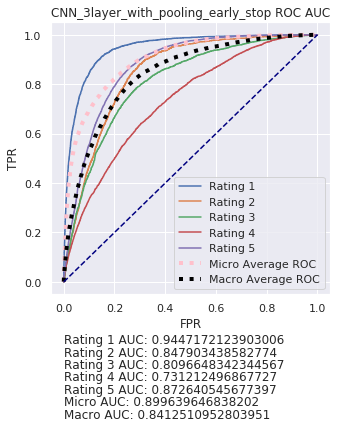

In [38]:

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(MODEL_NAME3, roc_auc3, fpr3, tpr3)

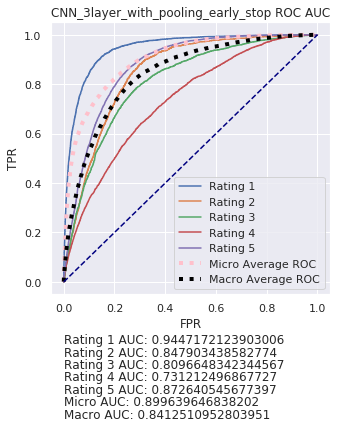

In [39]:

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(MODEL_NAME3, roc_auc3, fpr3, tpr3)